# Characters Classification with Neural Networks

In this notebook we are going to use the Neural Networks for image classification. We are going to use the same dataset of the lab on SVM: Kuzushiji-MNIST or K-MNIST for short (https://github.com/rois-codh/kmnist) a dataset of traditional japanese handwritten kana.

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

In [1]:
#load the required packages and check Scikit-learn version

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import sklearn
print ('scikit-learn version: ', sklearn.__version__)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

scikit-learn version:  0.24.1


In [2]:
# helper function to load KMNIST dataset from disk
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

# TODO 
Set as seed for the random generator your Student ID (you can use your "numero di matricola"). Try to change the seed to see the impact of the randomization.

In [3]:
ID = 10657643
np.random.seed(ID)

In [4]:
#load the MNIST dataset and let's normalize the features so that each value is in [0,1]
X, y = load_mnist("data")
print("Number of samples in the K-MNIST dataset:", X.shape[0])
# rescale the data
X = X / 255.0

Number of samples in the K-MNIST dataset: 60000


Now split into training and test. We start with a small training set of 600 samples to reduce computation time while 4000 samples will be used for testing. Make sure that each label is present at least 10 times in train and test set frequencies.

In [26]:
#random permute the data and split into training and test taking the first 600
#data samples as training and 4000 as test set
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

labelsT, freqsT = np.unique(y_test, return_counts=True)
print("Labels in test set: ", labels)
print("Frequencies in test set: ", freqs)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [57 56 57 72 63 66 54 63 50 62]
Labels in test set:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test set:  [57 56 57 72 63 66 54 63 50 62]


In [6]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

INPUT:


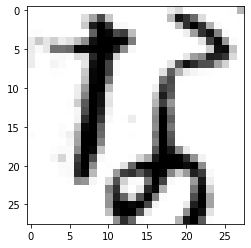

LABEL: 4




INPUT:


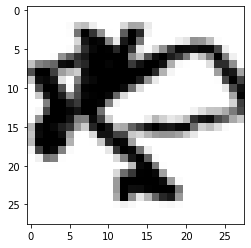

LABEL: 7




INPUT:


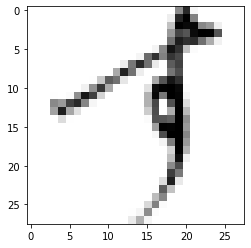

LABEL: 2


In [7]:
#let's try the plotting function
plot_input(X_train,y_train,10)
print("\n\n\n")
plot_input(X_test,y_test,100)
print("\n\n\n")
plot_input(X_test,y_test,1000)

### TO DO 1

Now use a feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter=100, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to 3 layers and, for each layer, its maximum size can be of 50. Evaluate the architectures you chose using GridSearchCV with cv=5.

You can reduce the number of iterations if the running time is too long on your computer.


In [8]:
# these are sample values but feel free to change them as you like, try to experiment with different sizes!!
parameters = {'hidden_layer_sizes': [(1,), (10,), (20,), (40,), (20,20,), (40,20,10)]}

mlp = MLPClassifier(max_iter=200, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,
                    learning_rate_init=.1)

grid = GridSearchCV(mlp, parameters, cv=5)
grid.fit(X_train, y_train)

print ('RESULTS FOR NN\n')

print("Best parameters set found:")
print(grid.best_params_)
print("\n")

print("Score with best parameters:")
print(grid.best_score_)

print("\nAll scores on the grid:")
print(grid.cv_results_["mean_test_score"])

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RESULTS FOR NN

Best parameters set found:
{'hidden_layer_sizes': (40,)}


Score with best parameters:
0.7666666666666667

All scores on the grid:
[0.22166667 0.71833333 0.75833333 0.76666667 0.73333333 0.70333333]


### TO DO 2

Now try also different batch sizes, while keeping the best NN architecture you have found above. Remember that the batch size was previously set to the default value, i.e., min(200, n_samples). 
Recall that a batch size of 1 corresponds to baseline SGD, while using all the 480 training samples (there are 600 samples but in cross validation with 5 folders we use 1/5 of them for validation at each round) corresponds to standard GD and using a different mini-batch size lies in the middle between the two extreme cases.

In [9]:
# these are sample values corresponding to baseline SGD, a reasonable mini-batch size and standard GD
# again feel free to change them as you like, try to experiment with different batch sizes!!
parameters = {'batch_size': [1, 20, 32, 100, 480]}

# need to specify that you would like to use the standard k-fold split otherwise sklearn create splits of different sizes
kf = sklearn.model_selection.KFold(n_splits=5)

mlp = MLPClassifier(max_iter=500, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID, hidden_layer_sizes = (40,),
                    learning_rate_init=.1)



grid = GridSearchCV(mlp, parameters, cv=kf)
grid.fit(X_train, y_train)

print ('RESULTS FOR NN\n')

print("Best parameters set found:")
print(grid.best_params_)
print("\n")

print("Score with best parameters:")
print(grid.best_score_)

print("\nAll scores on the grid:")
print(grid.cv_results_["mean_test_score"])

RESULTS FOR NN

Best parameters set found:
{'batch_size': 480}


Score with best parameters:
0.7783333333333333

All scores on the grid:
[0.12166667 0.75833333 0.76166667 0.77333333 0.77833333]


### QUESTION 1

What do you observe for different architectures and batch sizes? How do the number of layers and their sizes affect the performances? What do you observe for different batch sizes, in particular what happens to the training convergence for different batch sizes (notice that the algorithm could not converge for some batch sizes)?

## ANSWER
* The architecture with only $1$ hidden layer with $1$ neuron is the worst, as I expected.
  The best architecture is characterized by $1$ hidden layer with $40$ neurons. Despite this architecture has achieved  the best result, there aren't reasonable differences with the architectures made of $2$ hidden layers (with both $20$ neurons) or just $1$ hidden layer with $10$, $20$ neurons. Also the architecture made with $3$ hidden layer with respectively $40,20,10$ neurons, has achieved a good score.
  

  
* The worst batch size is $1$ (baseline SGD), wheras the best is $480$. Excluding the batch size = $1$, in this case there aren't evident differencies between the best case (batch size = $480$) and the others (batch size = $20,32,100$) 



* Using 100 iterations with batch size = $1$, the MLP doesn't converge (For this reason I have implemnted the algorithm with 500 iteratins). 

### TODO 3:

Plot the train and test accuracies as a function of the number of learnable parameters in your neural network. Print also the computation time for the various configurations you try (the code for getting the computation time is already provided). You can use 100 iterations (if you get a warning on convergence not reached it is not an issue for this lab)

Training MLP of size (1,) ...
Done, training time: 0.82 sec

Training MLP of size (10,) ...
Done, training time: 0.86 sec

Training MLP of size (20,) ...
Done, training time: 0.86 sec

Training MLP of size (40,) ...
Done, training time: 0.95 sec

Training MLP of size (20, 20) ...
Done, training time: 0.66 sec

Training MLP of size (40, 20, 10) ...
Done, training time: 0.78 sec



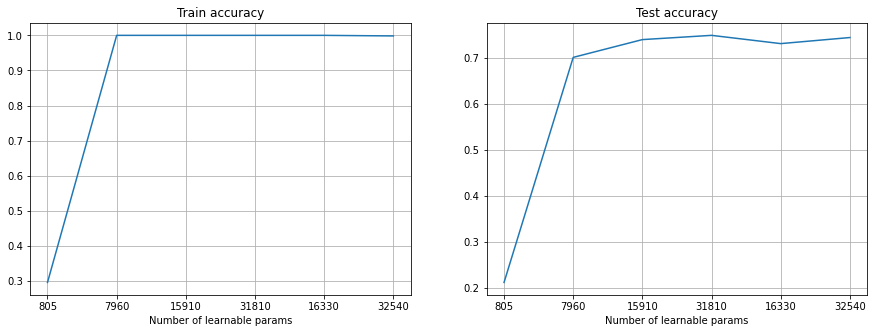

In [10]:
import time
from functools import reduce

# Function to compute the number of learnable parameters of a mlp given the size of its hidden layers
def param_count(hl_size):
    tot = 0
    input_size, output_size = X_train.shape[1], len(labels)
    tot += (input_size+1)*hl_size[0]
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size
    return tot

hl_sizes = [(1,), (10,), (20,), (40,), (20,20,), (40,20,10)]
hl_labels = [param_count(t) for t in hl_sizes]

ti = time.time()
train_acc_list, test_acc_list = [], []
for hl_size in hl_sizes:
    print('Training MLP of size {} ...'.format(hl_size))
    mlp = MLPClassifier(max_iter=300, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID, hidden_layer_sizes = hl_size, batch_size = 480,
                    learning_rate_init=.1)
    mlp.fit(X_train, y_train)
    
    train_acc_list.append(mlp.score(X_train, y_train))
    test_acc_list.append(mlp.score(X_test, y_test))
    print('Done, training time: {:.2f} sec\n'.format(time.time()-ti))
    ti = time.time()

fig, ax = plt.subplots(1,2, figsize=(15,5))


ax[0].plot(train_acc_list)
ax[0].set_xlabel('Number of learnable params')
ax[0].set_title('Train accuracy')
ax[0].set_xticks(np.arange(0,len(hl_labels)))
ax[0].set_xticklabels(hl_labels)
ax[0].grid(True)

ax[1].plot(test_acc_list)
ax[1].set_xlabel('Number of learnable params')
ax[1].set_title('Test accuracy')
ax[1].set_xticks(np.arange(0,len(hl_labels)))
ax[1].set_xticklabels(hl_labels)
ax[1].grid(True)


## Question 2:

Comment about the training and test accuracies referring to the discussion on underfitting and overfitting we did in the course

## ANSWER
* With $805$ learnable parameters there is a clear example of underfitting, so the model isn't able to learn. 
* Increasing the nuber of learnable parameters, the model becomes better, but there is a case of (not really big) over-fitting because the training accuracy is $100\%$ wheras the test accuracy is ~$75\%$ 

### TO DO 4

Now try also to use different learning rates, while keeping the best NN architecture and batch size you have found above. Plot the learning curves (i.e., the variation of the loss over the steps, you can get it from the loss_curve_ object of sklearn) for the different values of the learning rate. Try to run each training for 100 iterations. 

In [11]:
import matplotlib.pyplot as plt
import operator

lr_list = [0.0002, 0.002, 0.02, 0.2]
scores = {}

mlp = MLPClassifier(max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID, hidden_layer_sizes = (40,), batch_size = 480,)

parameters = {'learning_rate_init': lr_list}

grid = GridSearchCV(mlp, parameters, cv=5)
grid.fit(X_train, y_train)



print ('RESULTS FOR NN\n')

print("Best parameters set found:")
print(grid.best_params_)
print("\n")

print("Score with best parameters:")
print(grid.best_score_)

print("\nAll scores on the grid:")
print(grid.cv_results_["mean_test_score"])

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_

RESULTS FOR NN

Best parameters set found:
{'learning_rate_init': 0.2}


Score with best parameters:
0.765

All scores on the grid:
[0.12333333 0.505      0.75166667 0.765     ]


C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


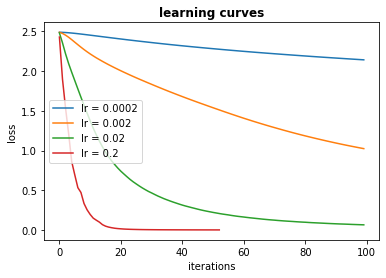

In [12]:
import matplotlib.pyplot as plt

lr_list = [0.0002, 0.002, 0.02, 0.2]
for lr in lr_list:
    mlp = MLPClassifier(max_iter=100, alpha=1e-4, learning_rate_init = lr, solver='sgd', tol=1e-4, random_state=ID, hidden_layer_sizes = (40,), batch_size = 480,)
    mlp.fit(X_train, y_train)
    plt.plot(mlp.loss_curve_, label= "lr = {}".format(lr))
    plt.legend(loc="best")
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.title("learning curves",fontweight="bold")

### QUESTION 3

Comment about the learning curves (i.e. the variation of the loss over the steps). How does the curve changes for different learning rates in terms of stability and speed of convergence ?

## ANSWER 

* Using $100$ iterations the worst learning rate is $0.0002$, in fact it's really slow, it doesn't converge, achieving the worst result;
* The values of $0.002$ and $0.02$  are faster than the case above, giving a better result, but neither in this case, using $100$ iterations, the neural network converges.
* The best learning rate parameter is $0.2$, that converges in less than $100$ iterations, scoring a $0.0$ loss value.


In all of this cases the loss curve is stable, but using a different a batch size ($32$ for example), I have noticed that the loss curve for a learning rate = $0.02$ is unstable.

### TO DO 5

Now get training and test error for a NN with best parameters (architecture, batch size and learning rate) from above. Plot the learning curve also for this case (you can run the training for 500 iterations).


RESULTS FOR BEST NN

Best NN training error: 0.000000
Best NN test error: 0.242000


Text(0.5, 1.0, 'learning curve for NN with best parameters')

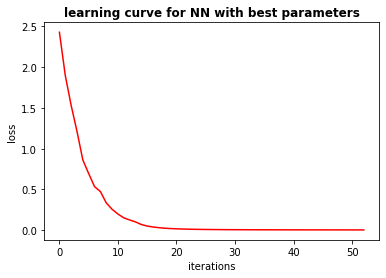

In [27]:
#get training and test error for the best NN model from CV

mlp_best = MLPClassifier(max_iter=500, alpha=1e-4, learning_rate_init = 0.2, solver='sgd', tol=1e-4, random_state=ID, hidden_layer_sizes = (40,), batch_size = 480,)
mlp_best.fit(X_train, y_train)

training_error = 1 - mlp_best.score(X_train, y_train)
test_error = 1 - mlp_best.score(X_test, y_test)
print ('\nRESULTS FOR BEST NN\n')

print ("Best NN training error: %f" % training_error)
print ("Best NN test error: %f" % test_error)

plt.plot(mlp.loss_curve_, color = "red")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("learning curve for NN with best parameters",fontweight="bold")

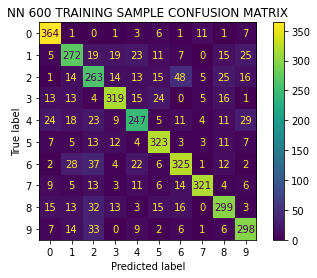

In [14]:
#I have plotted the confusion matrix of the NN trained with 600 training samples, tested on 4000 test samples
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(mlp_best, X_test, y_test)
plt.title("NN 600 TRAINING SAMPLE CONFUSION MATRIX")
plt.show()

## More data 
Now let's do the same but using 4000 (or less if it takes too long on your machine) data points for training. Use the same NN architecture as before, but you can try more if you like and have a powerful computer!!

In [28]:
X = X[permutation] 
y = y[permutation]

m_training = 4000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [405 401 400 410 387 401 400 378 413 405]


### TO DO 6

Now train the NNs with the added data points using the optimum parameters found above. Eventually, feel free to try different architectures if you like. We suggest that you use 'verbose=True' so have an idea of how long it takes to run 1 iteration (eventually reduce also the number of iterations to 50).

In [16]:
# use best architecture and params from before
print ('\nRESULTS FOR NN\n')

mlp_more_samples = MLPClassifier(max_iter=500, alpha=1e-4, learning_rate_init = 0.2, solver='sgd', tol=1e-4, random_state=ID, hidden_layer_sizes = (40,), batch_size = 480, verbose = True)
mlp_more_samples.fit(X_train, y_train)

training_error = 1 - mlp_more_samples.score(X_train, y_train)
test_error = 1 - mlp_more_samples.score(X_test, y_test)


print ("\n\nNN training error: %f" % training_error)
print ("NN test error: %f" % test_error)



RESULTS FOR NN

Iteration 1, loss = 1.73673865
Iteration 2, loss = 0.87855412
Iteration 3, loss = 0.57546597
Iteration 4, loss = 0.44607399
Iteration 5, loss = 0.36132077
Iteration 6, loss = 0.29545082
Iteration 7, loss = 0.25232764
Iteration 8, loss = 0.21979579
Iteration 9, loss = 0.18061522
Iteration 10, loss = 0.15722418
Iteration 11, loss = 0.12742238
Iteration 12, loss = 0.10900821
Iteration 13, loss = 0.09518846
Iteration 14, loss = 0.08019917
Iteration 15, loss = 0.07235118
Iteration 16, loss = 0.05835423
Iteration 17, loss = 0.05062173
Iteration 18, loss = 0.04247940
Iteration 19, loss = 0.03817686
Iteration 20, loss = 0.03271160
Iteration 21, loss = 0.02926171
Iteration 22, loss = 0.02574464
Iteration 23, loss = 0.02305218
Iteration 24, loss = 0.02055916
Iteration 25, loss = 0.01923753
Iteration 26, loss = 0.01726220
Iteration 27, loss = 0.01573778
Iteration 28, loss = 0.01470397
Iteration 29, loss = 0.01364045
Iteration 30, loss = 0.01260895
Iteration 31, loss = 0.01174262


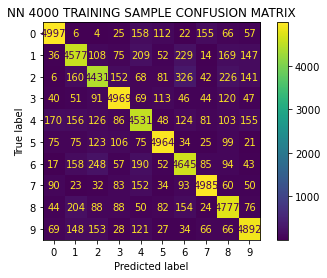

In [17]:
#I have plotted the confusion matrix of the NN trained with 4000 training samples, tested on 56000 test samples

plot_confusion_matrix(mlp_more_samples, X_test, y_test)
plt.title("NN 4000 TRAINING SAMPLE CONFUSION MATRIX")
plt.show()

## QUESTION 4
Compare the train and test error you got with a large number of samples with the best one you obtained with only 600 data points. Comment about the results you obtained.

### ANSWER 
 
Both model have achieved a training error = $0.00$, but on the test error, the best result has been obtained by the model trained with $4000$ samples. In fact the test error for the NN trained with $600$ training samples is $0.242$, wheras the test error for the NN trained with $4000$ training samples is ~ $0.147$. 


This result has been predictable, because with more training samples, the Neural Network learns better.


### TO DO 7

Plot an example that was missclassified by NN with m=600 training data points and it is now instead correctly classified by NN with m=4000 training data points.

In [18]:
NN_prediction = mlp_best.predict(X_test)
large_NN_prediction = mlp_more_samples.predict(X_test)

print(NN_prediction)
print(large_NN_prediction)

NN_misclassified = []
large_NN_misclassified = []

for i in range(len(NN_prediction)):
    if NN_prediction[i]!= y_test[i]:
        NN_misclassified.append(NN_prediction[i])
       
    
for i in range(len(large_NN_prediction)):
    if large_NN_prediction[i]!= y_test[i]:
        large_NN_misclassified.append(large_NN_prediction[i])
        

[3 0 8 ... 0 2 9]
[3 0 8 ... 9 2 9]


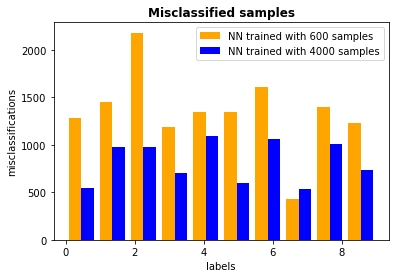

In [29]:
#Histogram of misclassified samples for the two neural network.
plt.style.use('seaborn-deep')

plt.hist([NN_misclassified, large_NN_misclassified], label=['NN trained with 600 samples', 'NN trained with 4000 samples'], color= ["orange","blue"])
plt.xlabel("labels")
plt.ylabel("misclassifications")
plt.legend(loc='best')
plt.title("Misclassified samples", fontweight = "bold")
plt.show()

This histogram shows how the Neural Network trained with $4000$ samples, classifies better than the other one trained with $600$ samples 

INPUT:


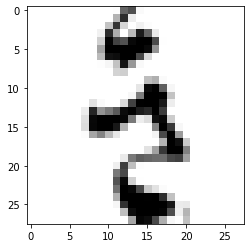

LABEL: 1
Wrong NN_prediction:  2
Right large_NN_prediction:  1


In [20]:
for i in range(len(y_test)):
    if(large_NN_prediction[i] == y_test[i] and NN_prediction[i] != y_test[i]):
        plot_input(X_test, y_test, i)
        print("Wrong NN_prediction: ", NN_prediction[i])
        print("Right large_NN_prediction: ", large_NN_prediction[i])
        break

### TO DO 8

Let's plot the weigths of the multi-layer perceptron classifier, for the best NN we get with 600 data points and with 4000 data points. The code is already provided, just fix variable names (e.g., replace mlp , mlp_large with your estimators) in order to have it working with your implementation



Weights with 600 data points:


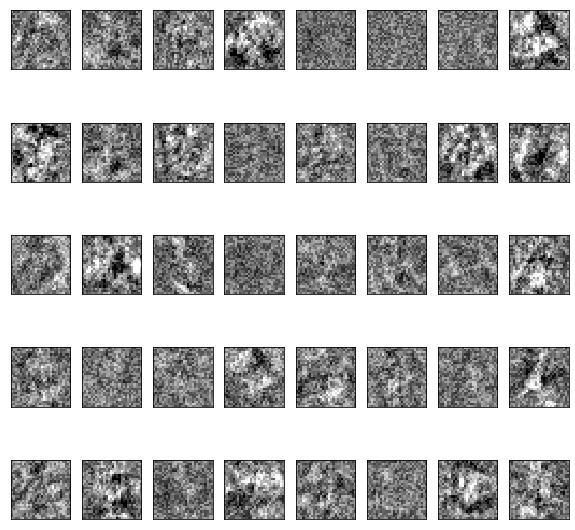

Weights with 4000 data points:


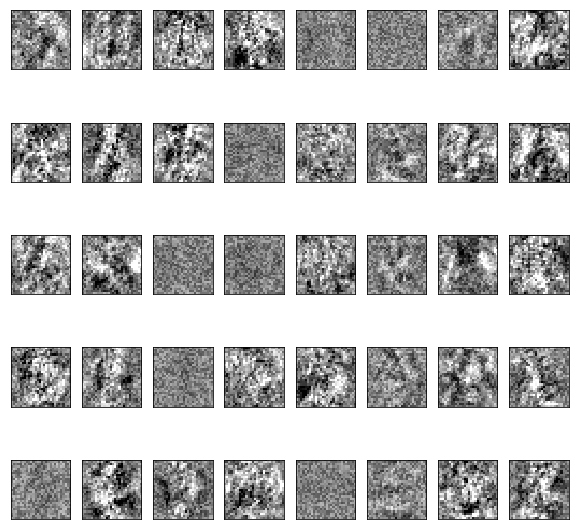

In [21]:
#ciascuna immagine rappresenta i pesi dei 784 pixel per un determinato neurone dell'hidden layer

print("Weights with 600 data points:")

fig, axes = plt.subplots(5, 8, figsize = (10,10))
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

print("Weights with 4000 data points:")

fig, axes = plt.subplots(5, 8,figsize = (10,10))
vmin, vmax = mlp_more_samples.coefs_[0].min(), mlp_more_samples.coefs_[0].max()
for coef, ax in zip(mlp_more_samples.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

## QUESTION 5

Describe what do you observe by looking at the weights.

### ANSWER 
In this problem, considering the difficult shapes of the japanise characters, it's hard to identify a pattern in the weights plot.


The plots of the Neural Network trained with $4000$ samples are less "confused" than the other's of the Neural Network trained with $600$ samples: there are black and white areas that can be well distinguished. This means that the Neural Network gives e more importance to the weights that are most useful for the classification of the image, and for this reason it achieves a better result.

### TO DO 9

Take the best SVM model and its parameters, you found in the last notebook. Fit it on a few data points and compute its training and test scores. Then fit also a logistic regression model with C=1. 

In [22]:
m_training = 5000   #5000 sample test

X_train, X_test = X[:m_training], X[m_training:2*m_training]
y_train, y_test = y[:m_training], y[m_training:2*m_training]

# use best parameters found in the SVM notebook, create SVM and perform fitting

svm = SVC(kernel = "rbf", C =10, gamma = 0.01)
svm.fit(X_train, y_train)

print ('RESULTS FOR SVM\n')

SVM_training_score =  svm.score(X_train, y_train)
SVM_test_score =  svm.score(X_test, y_test)

print("Training score SVM:")
print(SVM_training_score)
print("\n")

print("Test score SVM:")
print(round(SVM_test_score,3))


RESULTS FOR SVM

Training score SVM:
1.0


Test score SVM:
0.919


In [23]:
from sklearn.linear_model import LogisticRegression 

regL2 = LogisticRegression(penalty='l2', C= 1,max_iter=500)
regL2.fit(X_train, y_train)

print ('\nRESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION')

training_error =  1-regL2.score(X_train, y_train)
test_error =  1-regL2.score(X_test, y_test)

print ("Training error (reg): %f" % training_error)
print ("Test error (reg): %f" % test_error)


RESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION
Training error (reg): 0.022200
Test error (reg): 0.244400


## QUESTION 6
Compare the results of Logistic Regression, SVM and NN. Which one achieve the best results? 

### ANSWER 
The best model for the task of this problem is the Support Vector Machine, that achieves a test error = $0.081$ wheras the (best) Neural Network has obtained a test error = $0.147$.

The worst model, as expected, is the Logistic Regression, with a test error = $0.244$. 

If we want use a Neural Network to obtain a better performance, we could use a Convolutional Neural Network.